In [212]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from dolfin import *

plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [213]:
def transient_adv_1d_R11(nx, s, left_bc, right_bc, init_cond, dt_num, steps, theta_num):
    # Input
    # nx:     number of elements
    
    # Output
    # u:      the solution, dolfin function
    
    mesh_1d = IntervalMesh(nx, 0, 1)

    h = 1.0/nx
    adv = 1.0
    
    CFL = adv*dt_num/h
    
    print('Courant number = ', CFL)

    V = FunctionSpace(mesh_1d, 'CG', 1)
    u = TrialFunction(V)
    w = TestFunction(V)
    u0 = project(init_cond, V)
    
    
    u_list = []

    def boundary_L(x, on_boundary):
        return on_boundary and near(x[0], 0, DOLFIN_EPS)

    def boundary_R(x, on_boundary):
        return on_boundary and near(x[0], 1, DOLFIN_EPS)

    bc_L = DirichletBC(V, Constant(left_bc), boundary_L)
    bc_R = DirichletBC(V, Constant(right_bc), boundary_R)

    bc = [bc_L]
    
    dt = Constant(dt_num)
    one = Constant(1.0)
    
    def L(w, u):
        return w*Constant(adv)*u.dx(0)
        #return -Constant(adv)*u*w.dx(0)
        
        
    delta_u = u - u0
    W = 0.5
    ww = (w*s-L(w, u0))
    
    #F = (w*delta_u/dt + W*L(w, u - u0) - ww)*dx
        
    #a, L = lhs(F), rhs(F)
    
    theta = Constant(theta_num)
    
    a = ( w*u/dt + theta*L(w, u) )*dx
    L = ( w*u0/dt + w*s - (one-theta)*L(w, u0) )*dx

    u = Function(V)
    
    for i in range(steps):
        solve(a==L, u, bcs=bc)
        u0.assign(u)
        u_list.append(u0.copy())

    return u_list, V.dofmap().dofs(), V.tabulate_dof_coordinates().T[0] #vertex_to_dof_map(V)

In [214]:
def transient_adv_1d_DG(nx, s, init_cond, dt_num, steps, theta_num):
    
    mesh_1d = IntervalMesh(nx, 0, 1)

    h = 1.0/nx
    adv = 1.0
    
    CFL = adv*dt_num/h
    
    print('Courant number = ', CFL)

    V = FunctionSpace(mesh_1d, 'DG', 0)
    u = TrialFunction(V)
    w = TestFunction(V)
    u0 = project(init_cond, V)
    
    h = CellDiameter(mesh_1d)
    h_avg = (h('+') + h('-'))/2

    u_star = Function(V)
    u_star = interpolate(init_cond, V)
    
    bc = []
    
    dt = Constant(dt_num)
    one = Constant(1)

    theta = Constant(theta_num)

    u_list = []

    u = TrialFunction(V)
    
    # This is upwinding, forward in space.
    F = w*(u - u0)/dt*dx + Constant(adv)*w('-')*(u0('-') - u0('+'))*dS
    a, L = lhs(F), rhs(F)
    
    #F2 = v*(u - 0.5*(u_n + u_star))/dt*dx + 0.5*(u_star('-') - u_star('+'))*v('-')*dS
    #a2, L2 = lhs(F2), rhs(F2)
    
    u = Function(V)
    
    for i in range(steps):
        solve(a==L, u, bcs=bc)
        u0.assign(u)
        u_list.append(u.copy())
    
    return u_list, V.dofmap().dofs(), V.tabulate_dof_coordinates().T[0]

In [215]:
source = Constant(0.0)
left_bc = 1.0
right_bc = 0.0
#init_cond = Expression('(x[0]<=(sigma + x0) && x[0]>=(-sigma + x0)) ? cos(pi*(x[0] - x0)/sigma) : 0.0', degree=1, sigma = 0.12, x0=0.2)
init_cond = Expression('x[0]<=0.2 ? 1.0 : 0.0', degree=1)

u1, dof, coord1 = transient_adv_1d_R11(50, source, left_bc, right_bc, init_cond, dt_num=3.0/200, steps=40, theta_num=0.5)
u2, dof, coord2 = transient_adv_1d_DG(50, source, init_cond, dt_num=3.0/200, steps=40, theta_num=0.5)

Courant number =  0.75
Courant number =  0.75


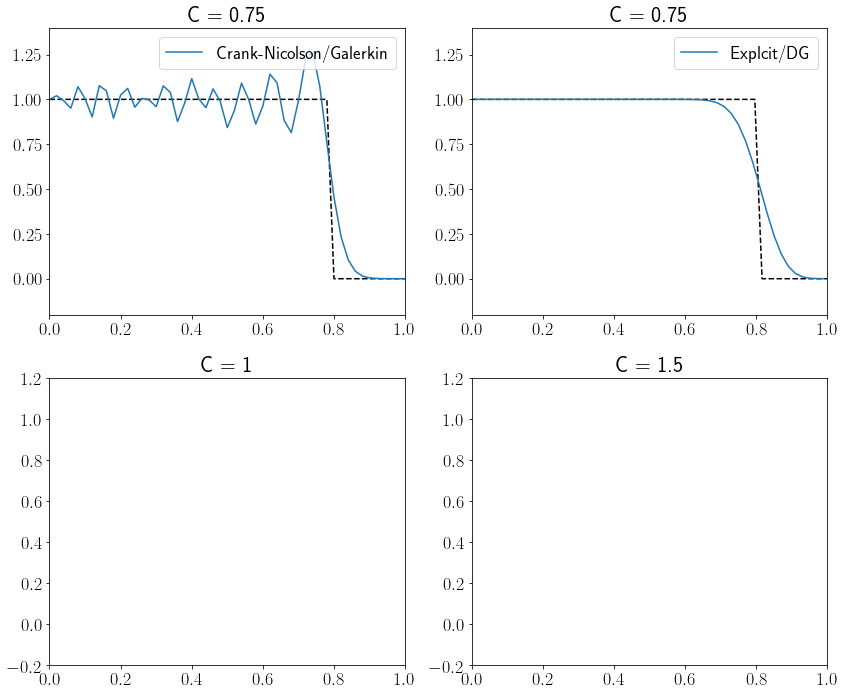

In [216]:
# Fig. 3.19 Propagation of a steep front using Galerkin and the Crank-Nicolson scheme
x_space = np.linspace(0,1,51)
x_space_DG = np.linspace(0,1,50)
x0 = 0.2
sigma = 0.12
sol_u_DG = np.zeros_like(x_space_DG)
sol_u_DG[x_space_DG<0.8] = 1.0

sol_u = np.zeros_like(x_space)
sol_u[x_space<0.8] = 1.0
#init_u = 0.5*(1.0 + np.cos(np.pi*(x_space - 0.2)/0.12))
#init_u[x_space > sigma + x0] = 0.0
#init_u[x_space < -sigma + x0] = 0.0

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax[0,0].plot(x_space, sol_u, c='k', ls='--')#, label='initial condition')
ax[0,0].plot(coord1, u1[-1].vector()[:], c='C0', label='Crank-Nicolson/Galerkin')

ax[0,0].set_ylim(-0.2, 1.4)
ax[0,0].set_xlim(0, 1.0)
#ax[0,0].set_ylabel('$u$', rotation=0, labelpad=25)
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('C = 0.75')

ax[0,1].plot(x_space_DG, sol_u_DG, c='k', ls='--')
ax[0,1].plot(coord2, u2[-1].vector()[:], c='C0', label='Explcit/DG')

ax[0,1].set_ylim(-0.2, 1.4)
ax[0,1].set_xlim(0, 1.0)
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('C = 0.75')

#ax[1,0].plot(x_space, init_u, c='k', ls='--')
#ax[1,0].plot(coord, u3[-1].vector()[:], c='C0')

ax[1,0].set_ylim(-0.2, 1.2)
ax[1,0].set_xlim(0, 1.0)
ax[1,0].set_title('C = 1')

#ax[1,1].plot(x_space, init_u, c='k', ls='--')
#ax[1,1].plot(coord, u4[-1].vector()[:], c='C0')

ax[1,1].set_ylim(-0.2, 1.2)
ax[1,1].set_xlim(0, 1.0)
ax[1,1].set_title('C = 1.5')

plt.tight_layout()
plt.show()